In [35]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import optuna
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

In [70]:
data = pd.read_csv('prices-split-adjusted.csv', parse_dates=True)
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [22]:
data.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import optuna
from statsmodels.tsa.arima.model import ARIMA

data = pd.read_csv('prices-split-adjusted.csv', parse_dates=['date'])

data_symbol = data[data['symbol'] == 'WLTW'].reset_index(drop=True)
data_symbol_open = data_symbol[['date', 'open']].rename(columns={'open': 'numb'})
data_symbol_close = data_symbol[['date', 'close']].rename(columns={'close': 'numb'})
data = pd.concat([data_symbol_open, data_symbol_close], axis=0, ignore_index=True)
data = data.sort_values(by='date')

data['time'] = data.groupby('date').cumcount().apply(lambda x: '08:00:00' if x == 0 else '16:00:00')
data['date'] = pd.to_datetime(data['date'].astype(str) + ' ' + data['time'])
data.set_index('date', inplace=True)
data.drop(columns='time', inplace=True)
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

start_date = data.index.min().floor('d')
end_date = data.index.max().floor('d')
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
all_dates_df = pd.DataFrame({
    'date': np.tile(all_dates, 2),
    'time': np.repeat(['08:00:00', '16:00:00'], len(all_dates))
})
all_dates_df['date'] = pd.to_datetime(all_dates_df['date'].astype(str) + ' ' + all_dates_df['time'])
all_dates_df.drop(columns='time', inplace=True)
all_dates_df.set_index('date', inplace=True)
full_data = all_dates_df.join(data, how='left')
full_data['numb'] = full_data['numb'].fillna(method='bfill')
full_data = full_data.sort_index()

In [2]:
full_data.to_csv('own_data.csv')

In [3]:
full_data.shape

(722, 1)

In [4]:
full_data = full_data.dropna()

In [40]:
start_date = '2016-12-01'
end_date = '2016-12-30'
train = full_data[full_data.index < start_date]
test = full_data[(full_data.index >= start_date) & (full_data.index < end_date)]

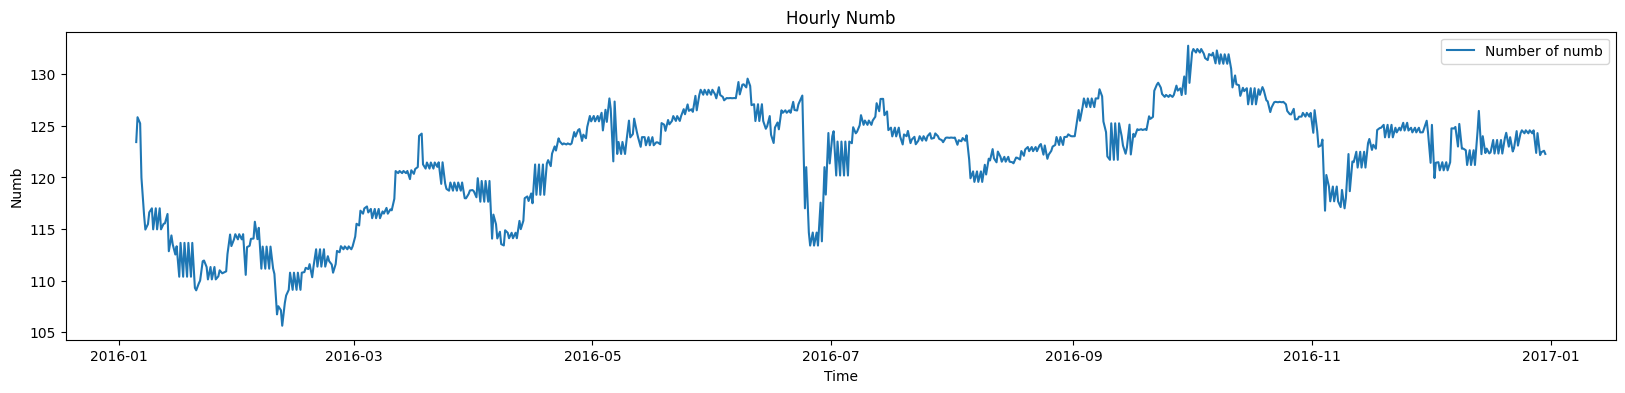

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.plot(full_data.index, full_data['numb'], label='Number of numb')
plt.xlabel('Time')
plt.ylabel('Numb')
plt.title('Hourly Numb')
plt.legend()
plt.show()

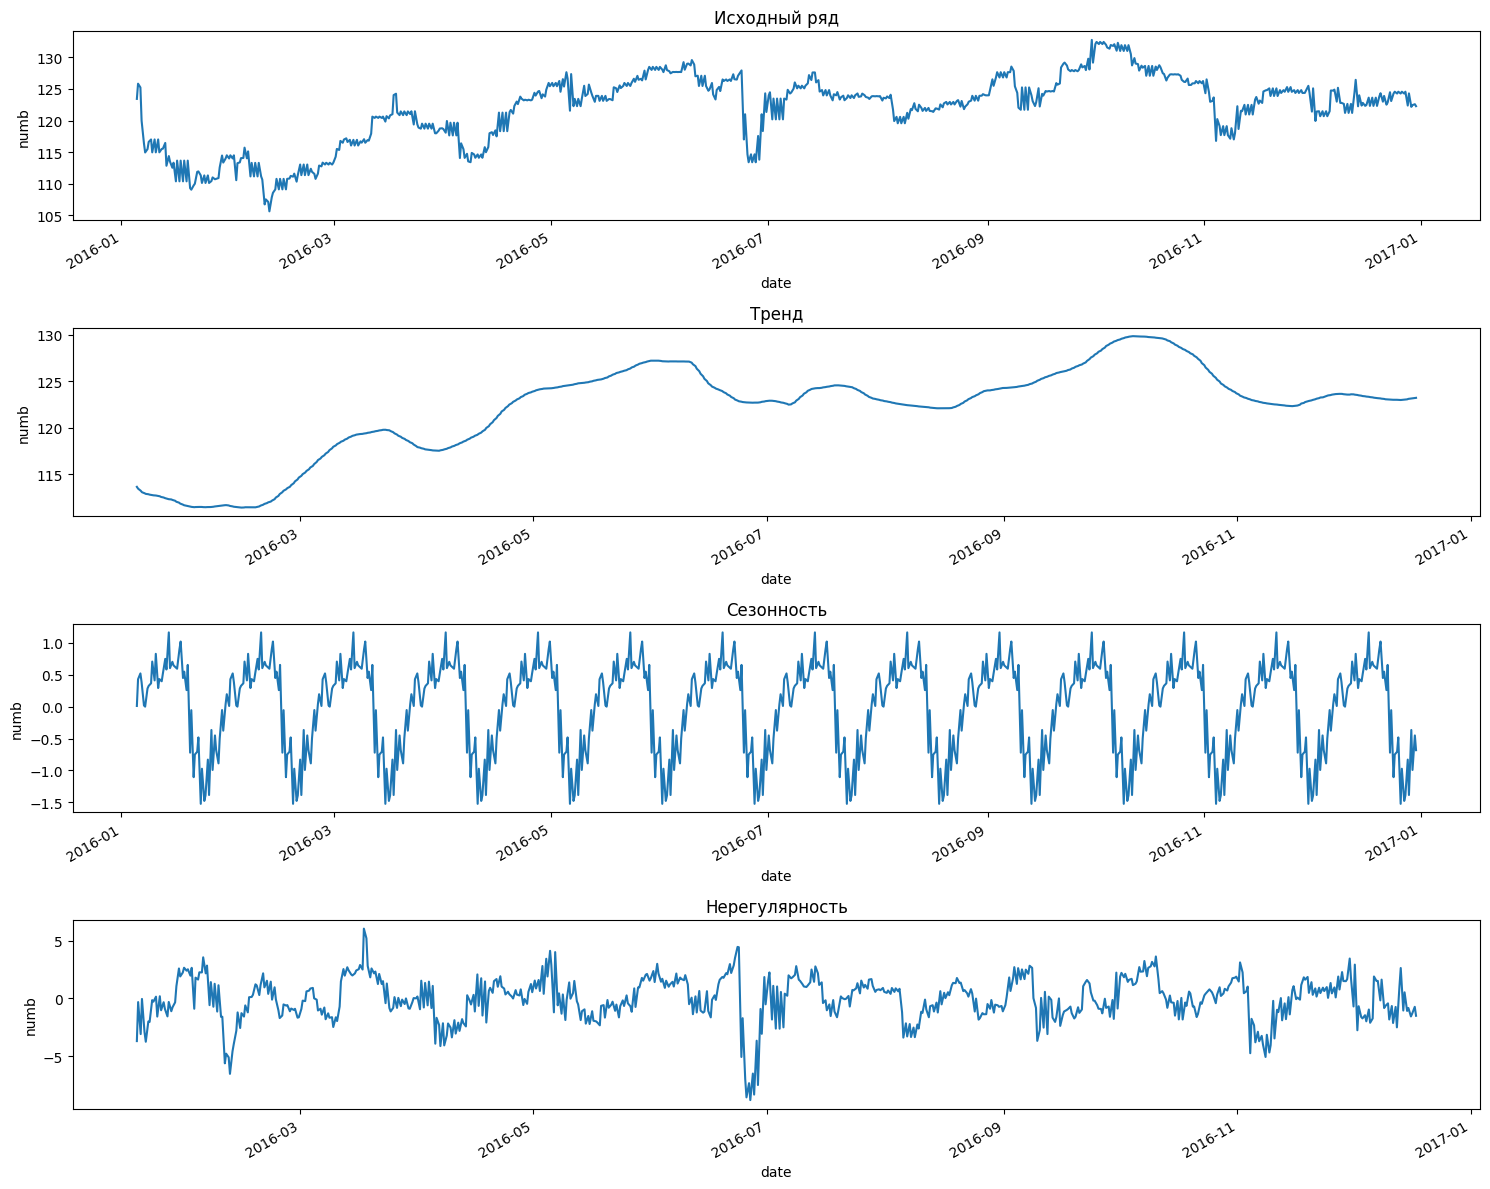

In [6]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(full_data['numb'], model='additive', period=52)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Исходный ряд
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('numb')
ax1.set_title('Исходный ряд')

# Тренд
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('numb')
ax2.set_title('Тренд')

# Сезонность
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('numb')
ax3.set_title('Сезонность')

# Остатки
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('numb')
ax4.set_title('Нерегулярность')

plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

adata_test = adfuller(full_data)
print(f'p-value = {adata_test[1]}')
if adata_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 0.16250877310152784
Ряд не стационарен


<Axes: title={'center': 'Rolling Mean over 12 month period'}, xlabel='date'>

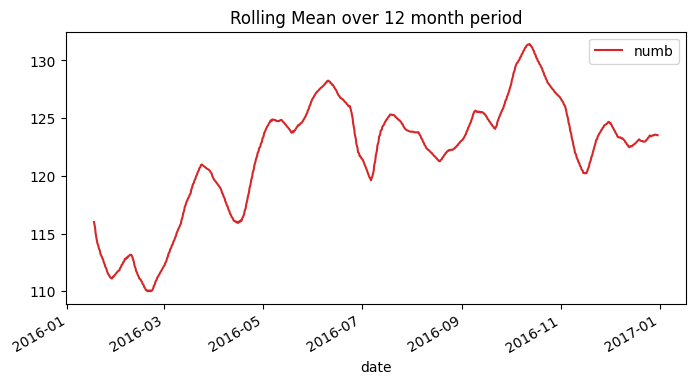

In [12]:
full_data.rolling(window = 26).mean().plot(figsize=(8,4), color="tab:red", title="Rolling Mean over 12 month period")

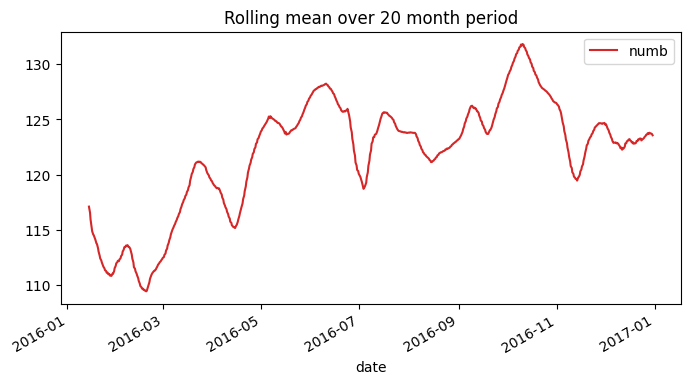

In [9]:
full_data.rolling(window = 20).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean over 20 month period")

<Axes: title={'center': 'Rolling Variance over 12 month period'}, xlabel='date'>

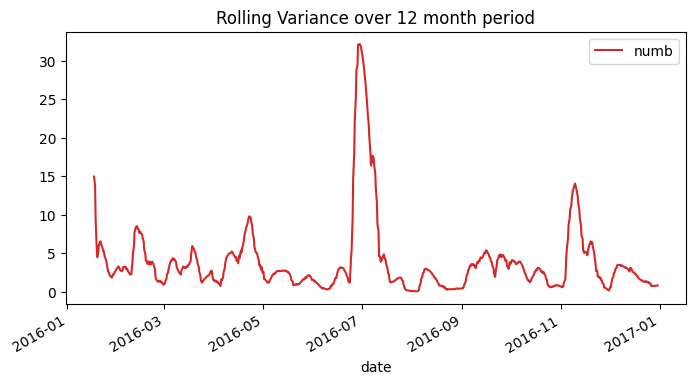

In [11]:
full_data.rolling(window = 26).var().plot(figsize=(8,4), color="tab:red", title="Rolling Variance over 12 month period")

<Axes: title={'center': 'Original Values'}, xlabel='date'>

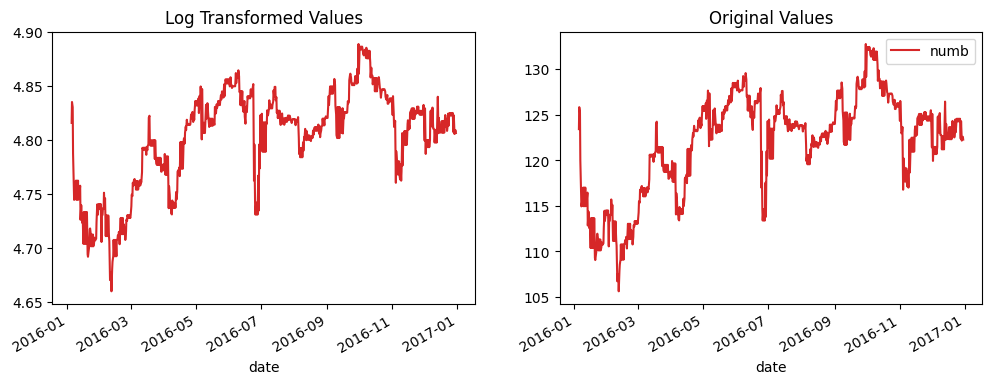

In [14]:
logged_data = full_data["numb"].apply(lambda x: np.log(x))

ax1 = plt.subplot(121)
logged_data.plot(figsize=(12,4),color="tab:red", title="Log Transformed Values", ax=ax1)
ax2 = plt.subplot(122)
full_data.plot(color="tab:red", title="Original Values", ax=ax2)

<Axes: title={'center': 'Differenced With Rolling Mean over 12 month'}, xlabel='date'>

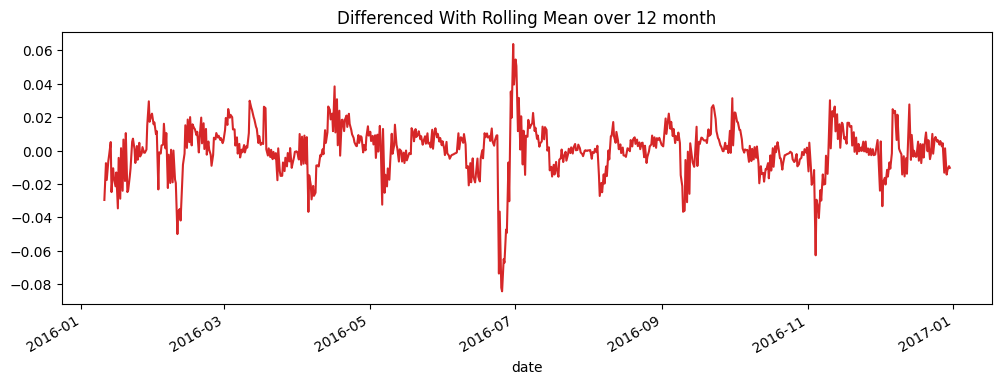

In [25]:
rolling_mean = logged_data.rolling(window = 12).mean()
rolled_detrended = logged_data - rolling_mean

#ax1 = plt.subplot(121)
rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month")
#ax2 = plt.subplot(122)
#full_data.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2)

In [28]:
adata_test = adfuller(rolled_detrended.dropna())
print(f'p-value = {adata_test[1]}')
if adata_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 2.696266368848797e-13
Ряд стационарен


In [29]:
rolled_detrended = rolled_detrended.dropna()

In [33]:
start_date = '2016-12-01'
end_date = '2016-12-30'
train_f = rolled_detrended[rolled_detrended.index < start_date]
test_f = rolled_detrended[(rolled_detrended.index >= start_date) & (rolled_detrended.index < end_date)]

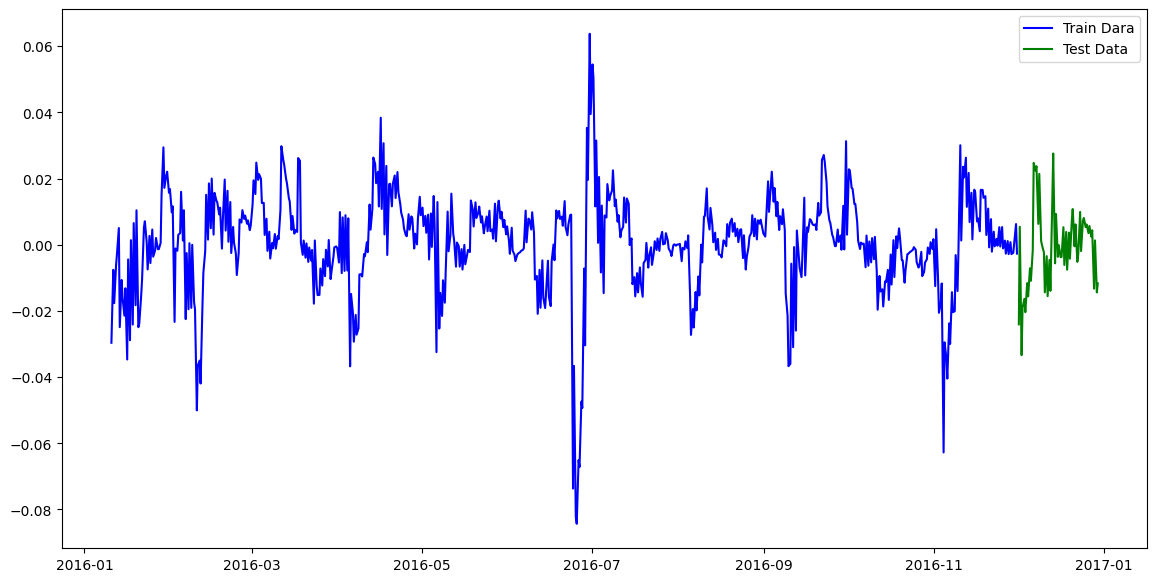

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.legend()
plt.show()

## Метод Хольта

In [58]:
model_holt = ExponentialSmoothing(train_f, damped_trend=False, trend=None, 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=33).fit()

forecast_holt = model_holt.forecast(steps=len(test_f))
forecast_holt.index = test_f.index
rolling_mean_test = rolling_mean.loc[forecast_holt.index].dropna()

common_index = forecast_holt.index.intersection(rolling_mean_test.index)
forecast_holt = forecast_holt.loc[common_index]
rolling_mean_test = rolling_mean_test.loc[common_index]
forecast_holt_restored = forecast_holt + rolling_mean_test

forecast_holt_exp = np.exp(forecast_holt_restored)
test_resized = test.loc[forecast_holt_exp.index, "numb"]

if len(test_resized) == len(forecast_holt_exp) and len(test_resized) > 0:
    mae_holt = mean_absolute_error(test_resized, forecast_holt_exp)
    print(f'Holt-Winters MAE: {mae_holt}')

Holt-Winters MAE: 1.16747206154222


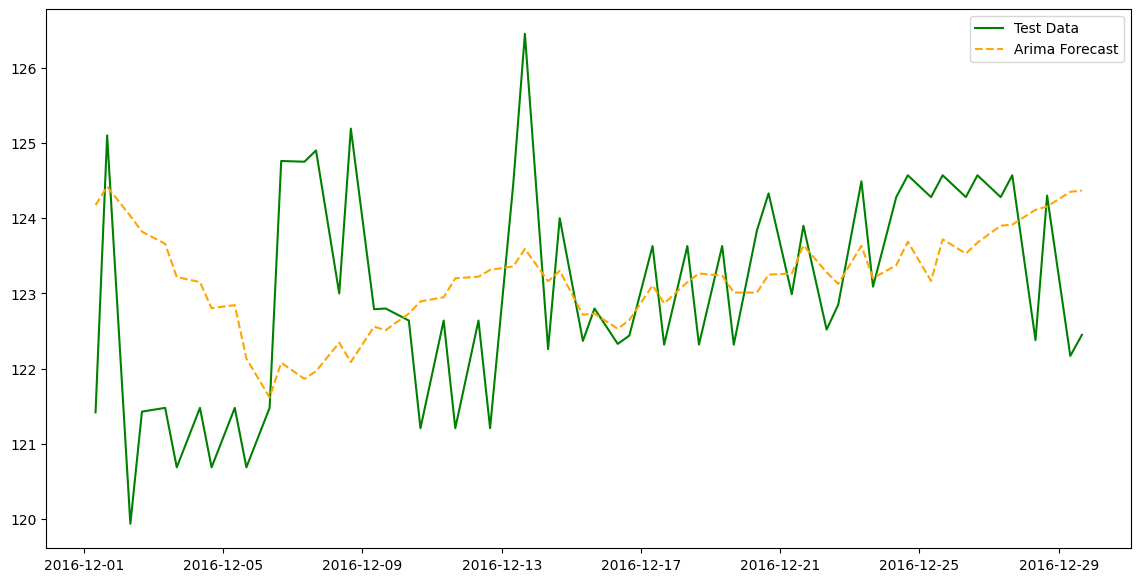

In [59]:
plt.figure(figsize=(14, 7))
plt.plot(test_resized.index, test_resized, label='Test Data', color='g')
plt.plot(test_resized.index, forecast_holt_exp, label='Arima Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error, accuracy_score

def get_behavior(series):
    return (series.diff() > 0).astype(int)  # 1 для повышения, 0 для понижения


test_b = get_behavior(test_resized)
forc_b = get_behavior(forecast_holt_exp)

accuracy = accuracy_score(test_b, forc_b)
print(f'Accuracy of behavior prediction: {accuracy:.2f}')

Accuracy of behavior prediction: 0.66


## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


def objective(trial):
    p = trial.suggest_int('p', 0, 20)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 20)
    
    # Создание и обучение модели ARIMA
    model = ARIMA(train_f, order=(p, d, q))
    try:
        model_fit = model.fit()
    except ValueError as e:
        return float("inf")  # Возвращаем бесконечное значение при ошибке

    # Прогнозирование
    forecast_arima = model_fit.get_forecast(steps=len(test_f)).predicted_mean
    forecast_arima.index = test_f.index
    rolling_mean_test = rolling_mean.loc[forecast_arima.index].dropna()

    common_index = forecast_arima.index.intersection(rolling_mean_test.index)
    forecast_arima = forecast_arima.loc[common_index]
    rolling_mean_test = rolling_mean_test.loc[common_index]
    forecast_arima_restored = forecast_arima + rolling_mean_test

    forecast_arima_exp = np.exp(forecast_arima_restored)
    test_resized = test.loc[forecast_arima_exp.index, "numb"]
    
    # Оценка модели
    mae = mean_absolute_error(test_resized, forecast_arima_exp)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Parameters:", best_params)

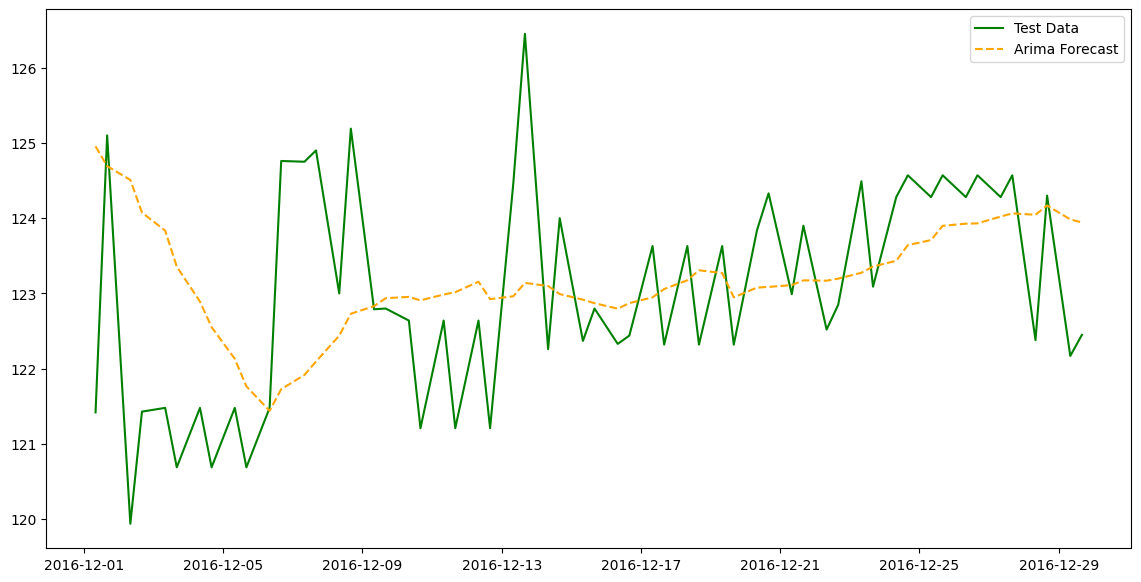

In [65]:
model = ARIMA(train_f, order=(7,0,16))
model_fit = model.fit()

forecast_arima = model_fit.get_forecast(steps=len(test_f)).predicted_mean
forecast_arima.index = test_f.index
rolling_mean_test = rolling_mean.loc[forecast_arima.index].dropna()

common_index = forecast_arima.index.intersection(rolling_mean_test.index)
forecast_arima = forecast_arima.loc[common_index]
rolling_mean_test = rolling_mean_test.loc[common_index]
forecast_arima_restored = forecast_arima + rolling_mean_test

forecast_arima_exp = np.exp(forecast_arima_restored)
test_resized = test.loc[forecast_arima_exp.index, "numb"]

plt.figure(figsize=(14, 7))
plt.plot(test_resized.index, test_resized, label='Test Data', color='g')
plt.plot(test_resized.index, forecast_arima_exp, label='Arima Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

In [64]:
mae_arima = mean_absolute_error(test_resized, forecast_arima_exp)
print(f'Arima MAE: {mae_arima}')

Arima MAE: 1.1673203159184382


In [66]:
test_b = get_behavior(test_resized)
forc_b = get_behavior(forecast_arima_exp)

accuracy = accuracy_score(test_b, forc_b)
print(f'Accuracy of behavior prediction: {accuracy:.2f}')

Accuracy of behavior prediction: 0.62


## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train = np.arange(len(train_f)).reshape(-1, 1)  # Простое временное представление
y_train = train_f
X_test = np.arange(len(train_f), len(train_f) + len(test_f)).reshape(-1, 1)
y_test = test_f

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 3, 60)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    # Создание и обучение модели RandomForestRegressor
    model_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    model_rf.fit(X_train, y_train)
    
    # Прогнозирование
    forecast_rf = model_rf.predict(X_test)
    
    # Преобразование результата в Pandas Series с индексами из тестовых данных
    forecast_rf_series = pd.Series(forecast_rf, index=test_f.index)
    
    # Восстановление тренда
    rolling_mean_test = rolling_mean.loc[forecast_rf_series.index].dropna()
    
    common_index = forecast_rf_series.index.intersection(rolling_mean_test.index)
    forecast_rf_series = forecast_rf_series.loc[common_index]
    rolling_mean_test = rolling_mean_test.loc[common_index]
    
    forecast_rf_restored = forecast_rf_series + rolling_mean_test

    # Обратное логарифмирование
    forecast_rf_exp = np.exp(forecast_rf_restored)
    
    # Приведение тестовых данных к необходимой длине для вычисления MAE
    test_resized = test.loc[forecast_rf_exp.index, "numb"]
    
    # Оценка модели
    mae = mean_absolute_error(test_resized, forecast_rf_exp)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Parameters:", best_params)

In [69]:
model_rf = RandomForestRegressor(n_estimators=375, max_depth=25, min_samples_split=2, random_state=42)
model_rf.fit(X_train, y_train)

forecast_rf = model_rf.predict(X_test)
forecast_rf_series = pd.Series(forecast_rf, index=test_f.index)

rolling_mean_test = rolling_mean.loc[forecast_rf_series.index].dropna()

common_index = forecast_rf_series.index.intersection(rolling_mean_test.index)
forecast_rf_series = forecast_rf_series.loc[common_index]
rolling_mean_test = rolling_mean_test.loc[common_index]

forecast_rf_restored = forecast_rf_series + rolling_mean_test
forecast_rf_exp = np.exp(forecast_rf_restored)
test_resized = test.loc[forecast_rf_exp.index, "numb"]

mae = mean_absolute_error(test_resized, forecast_rf_exp)
print(f'RandomForestRegressor MAE = {mae}')

RandomForestRegressor MAE = 1.1517612328186662


In [70]:
test_b = get_behavior(test_resized)
forc_b = get_behavior(forecast_rf_exp)

accuracy = accuracy_score(test_b, forc_b)
print(f'Accuracy of behavior prediction: {accuracy:.2f}')

Accuracy of behavior prediction: 0.57


# <strong>Итог работы с преобразованным рядом</strong>:
## <strong>Метод Хольта</strong>: MAE 1.16747206154222, Accuracy of behavior 0.66
## <strong>ARIMA</strong>: MAE 1.1673203159184382, Accuracy of behavior 0.62
## <strong>RandomForestRegressor</strong>: MAE 1.1517612328186662, Accuracy of behavior 0.57